# Gauss-Newton for XRD

In [50]:
from XRDXRFutils import GaussNewton,DataXRD,SpectraXRD,DatabaseXRD,PhaseList

from matplotlib.pyplot import xlim,ylim,xlabel,ylabel,legend,plot,fill_between,imshow,subplots,sca,savefig,figure,colorbar
from numpy import prod,array,minimum,maximum,log,zeros,trapz,where,amax,max,sqrt,sign,fabs,exp,linspace
from numpy.linalg import eig,det
from multiprocessing import Pool

### loading data

In [2]:
path = '/home/zdenek/Projects/pyMaXRDXRF/M491/ProfiloXRD/'


data = DataXRD().load_h5(path + 'xrd.h5')
data.opt = [-1186.6, 1960.3, 51]

database = DatabaseXRD().read_cifs('/home/zdenek/Projects/XRDXRFutils/Database')

lazurite = database['Lazurite'][0]
hydrocerussite = database['Hydrocerussite'][0]
cinnabar = database['Cinnabar'][1]
barite = database['Barite'][0]
spinel = database['Spinel'][0]
calcite = database['Calcite'][0]
hematite = database['Hematite'][4]

phases = PhaseList([hydrocerussite,lazurite,cinnabar])
phases = PhaseList([hydrocerussite,lazurite,cinnabar,
                    PhaseList([hydrocerussite,cinnabar]),
                    PhaseList([hydrocerussite,lazurite]),
                    PhaseList([cinnabar,lazurite])])

Loading: /home/zdenek/Projects/pyMaXRDXRF/M491/ProfiloXRD/xrd.h5


In [3]:
class PhaseSearch(list):
    """
    Class to perform phase search.
    """
    def __init__(self,phases,spectra):
        super().__init__([GaussNewton(phase,spectra) for phase in phases])
        
        self.spectra = spectra
        self.intensity = spectra.intensity
        
        self.opt = self[0].opt
        for g in self:
            g.opt = self.opt
        
    def minimize_gamma(self,n=8):
        for g in self:
            for i in range(n):
                g.minimize_gamma()
    
    def area_fit(self):
        return array([g.area_fit() for g in self])
    
    def area_0(self):
        return array([g.area_0() for g in self])
    
    def overlap_0(self):
        return array([g.overlap_0() for g in self])
    
    def overlap_area(self):
        return array([g.overlap_area() for g in self])
    
    def loss(self):
        return array([g.loss() for g in self])
    
    def select(self):
        idx = self.overlap_area().argmax()
        selected = self[idx]
        
        self.idx = idx
        self.selected = selected
        
        return selected
    
    def theta_correction(self,n=8):
        for i in range(n):
            self.select().calibration()
            
    def search(self):
        
        self.minimize_gamma()
        
        self.select()
        self.theta_correction()
        self.minimize_gamma()
        
        self.select()
        self.theta_correction()
        self.minimize_gamma()
        
        return self
    
class PhaseMap(list):
    """
    Class to process images
    """      
    def from_data(self,data,phases):
    
        phases.get_theta(max_theta=53,min_intensity=0.05)
        arr = data.data.reshape(-1,1280)

        spectras = self.gen_spectras(arr)        
        for spectra in spectras:
            spectra.opt = [-1186.6, 1960.3, 51]
        
        self += [PhaseSearch(phases,spectra) for spectra in spectras]
        
        return self
    
    @staticmethod
    def f_spectra(x):
        return SpectraXRD().from_array(x)

    def gen_spectras(self,a):
        with Pool() as p:
            spectras = p.map(self.f_spectra,a)
        return spectras
    
    @staticmethod
    def f_search(x):
        return x.search()
    
    def search(self):
        with Pool() as p:
            result = p.map(self.f_search,self)
        return PhaseMap(result)

In [4]:
%%time
pm = PhaseMap().from_data(data,phases)

CPU times: user 2.71 s, sys: 892 ms, total: 3.6 s
Wall time: 3.21 s


In [5]:
%%time
result = pm.search()

CPU times: user 12.9 s, sys: 3.23 s, total: 16.1 s
Wall time: 9min 22s


[-1180.9701095977778, 1951.025726437812, 51]


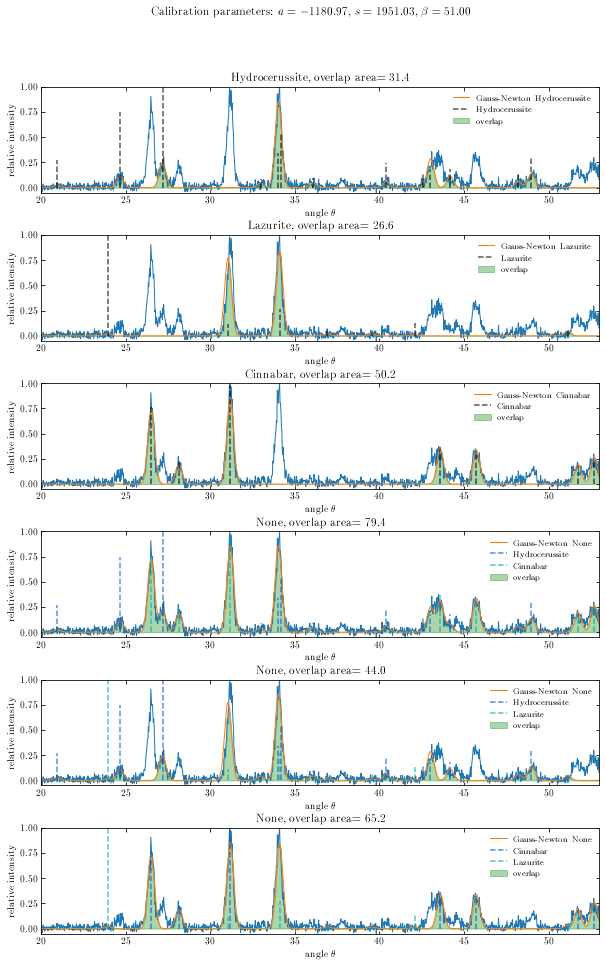

In [20]:
%matplotlib inline

r = result[1600]
#r = result[160]
#r = result[2905]
#r = result[5878]

#loc_phases = PhaseList([PhaseList([hydrocerussite,cinnabar])])
#loc_phase_search = PhaseSearch(loc_phases,r.spectra).search()

fig,ax = subplots(len(r),1,figsize=(10,14))
fig.subplots_adjust(hspace=0.4,bottom=0.06,top=0.9)
print(r.opt)

fig.suptitle(r'Calibration parameters: $a = %.2f$, $s=%.2f$, $\beta=%.2f$'%(r.opt[0],r.opt[1],r.opt[2]))
                  
for i,g in enumerate(r):
    
    sca(ax[i])
    
    ax[i].set_title('%s, overlap area= %.1f'%(g.label,g.overlap_area()))
    g.plot_spectra(lw=1)
    g.plot('-',label='Gauss-Newton %s'%g.label,lw=1)
    #g.phase.plot('r',alpha=0.66)
    g.phase.plot(alpha=0.66)

    fill_between(g.theta,g.overlap(),color='g',alpha=0.33,label='overlap')

    legend(frameon=False)
    ylim(-0.05,1)
    xlim(20,53)
    xlabel(r'angle $\theta$')
    ylabel(r'relative intensity')
    
#savefig('doc/calibrated_phases.png')
#savefig('doc/calibrated_phases.pdf')

[-1180.9701095977778, 1951.025726437812, 51]


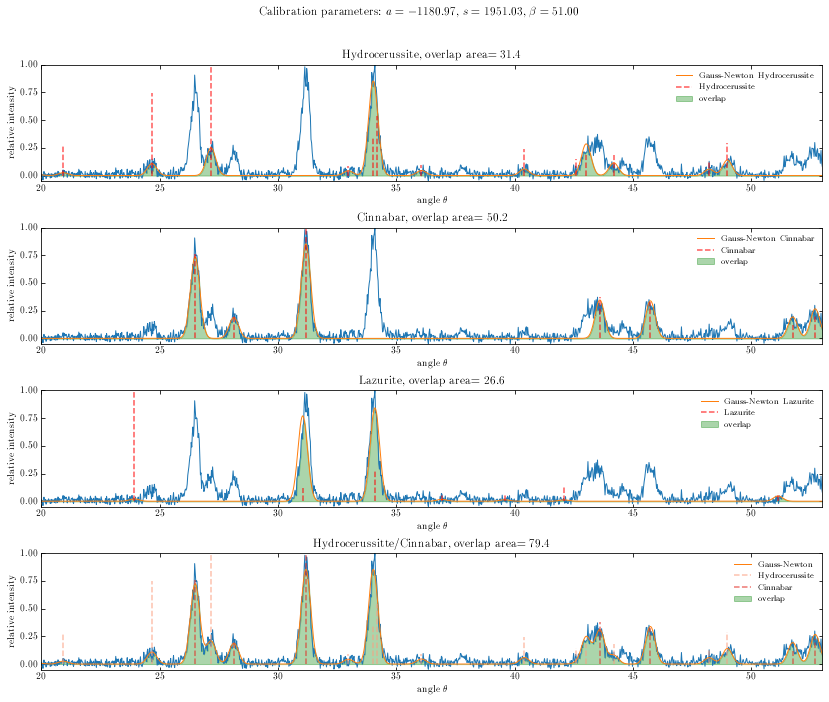

In [43]:
%matplotlib inline

r = result[1600]

fig,ax = subplots(4,1,figsize=(14,10))
fig.subplots_adjust(hspace=0.4,bottom=0.06,top=0.9)
print(r.opt)

fig.suptitle(r'Calibration parameters: $a = %.2f$, $s=%.2f$, $\beta=%.2f$'%(r.opt[0],r.opt[1],r.opt[2]))
                  
g = r[0]
sca(ax[0])

ax[0].set_title('%s, overlap area= %.1f'%(g.label,g.overlap_area()))
g.plot_spectra(lw=1)
g.plot('-',label='Gauss-Newton %s'%g.label,lw=1)
g.phase.plot('r',alpha=0.66)

fill_between(g.theta,g.overlap(),color='g',alpha=0.33,label='overlap')

legend(frameon=False)
ylim(-0.05,1)
xlim(20,53)
xlabel(r'angle $\theta$')
ylabel(r'relative intensity')

g = r[2]
sca(ax[1])

ax[1].set_title('%s, overlap area= %.1f'%(g.label,g.overlap_area()))
g.plot_spectra(lw=1)
g.plot('-',label='Gauss-Newton %s'%g.label,lw=1)
g.phase.plot('r',alpha=0.66)

fill_between(g.theta,g.overlap(),color='g',alpha=0.33,label='overlap')

legend(frameon=False)
ylim(-0.05,1)
xlim(20,53)
xlabel(r'angle $\theta$')
ylabel(r'relative intensity')

g = r[1]
sca(ax[2])

ax[2].set_title('%s, overlap area= %.1f'%(g.label,g.overlap_area()))
g.plot_spectra(lw=1)
g.plot('-',label='Gauss-Newton %s'%g.label,lw=1)
g.phase.plot('r',alpha=0.66)

fill_between(g.theta,g.overlap(),color='g',alpha=0.33,label='overlap')

legend(frameon=False)
ylim(-0.05,1)
xlim(20,53)
xlabel(r'angle $\theta$')
ylabel(r'relative intensity')

g = r[3]
sca(ax[3])

ax[3].set_title('%s, overlap area= %.1f'%('Hydrocerussitte/Cinnabar',g.overlap_area()))
g.plot_spectra(lw=1)
g.plot('-',label='Gauss-Newton',lw=1)
g.phase.plot('Reds',alpha=0.66)

fill_between(g.theta,g.overlap(),color='g',alpha=0.33,label='overlap')

legend(frameon=False)
ylim(-0.05,1)
xlim(20,53)
xlabel(r'angle $\theta$')
ylabel(r'relative intensity')

savefig('doc/fits.png',dpi=900)

[-1190.4625675223688, 1965.858783472337, 51]


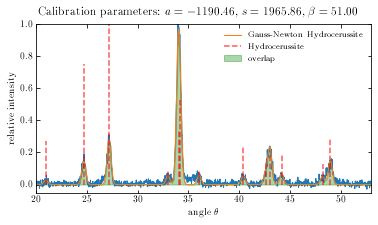

In [64]:
%matplotlib inline

r = result[160]

fig = figure(figsize=(6,3))
fig.subplots_adjust(hspace=0.4,bottom=0.12,top=0.9)
print(r.opt)

fig.suptitle(r'Calibration parameters: $a = %.2f$, $s=%.2f$, $\beta=%.2f$'%(r.opt[0],r.opt[1],r.opt[2]))
                  
g = r[0]

#title('%s, overlap area= %.1f'%(g.label,g.overlap_area()))
g.plot_spectra(lw=1)
g.plot('-',label='Gauss-Newton %s'%g.label,lw=1)
g.phase.plot('r',alpha=0.66)

fill_between(g.theta,g.overlap(),color='g',alpha=0.33,label='overlap')

legend(frameon=False)
ylim(-0.05,1)
xlim(20,53)
xlabel(r'angle $\theta$')
ylabel(r'relative intensity')

savefig('doc/fit_hydrocerussite.png',dpi=900)

## Calibration

per pixel calibration dependence

a,b: [  -0.50226844 -202.39609634] [ -0.80069482 382.26914059]
-1186.0849464892906 1958.492252418211


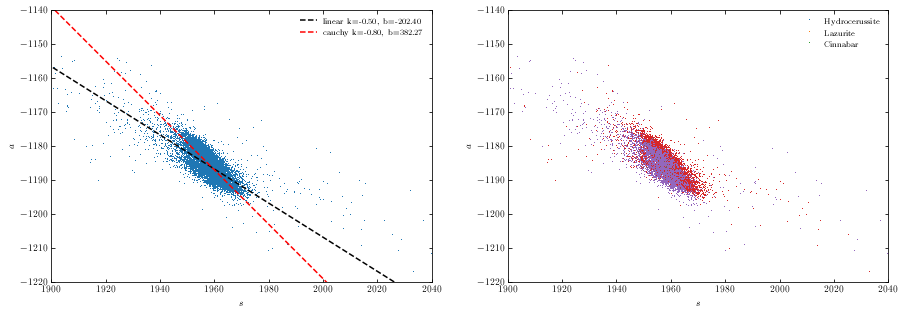

In [8]:
%matplotlib inline
from numpy import linspace
from scipy.optimize import curve_fit,least_squares

def f(x,a,b):
    return a*x + b
def loss(x,t,y):
    return (x[0]*t + x[1]) - y

a = array([r.selected.opt[0] for r in result])
s = array([r.selected.opt[1] for r in result])
idx = array([r.idx for r in result])
x = linspace(s.min(),s.max())

opt,var = curve_fit(f,s,a)

res = least_squares(loss,x0=opt,args=(s,a),loss='cauchy')
print('a,b:',opt,res['x'])

linear_y = f(x,*opt)
cauchy_y = f(x,*res['x'])

fig,ax = subplots(1,2,figsize=(15,5))

sca(ax[0])
plot(s,a,',')
plot(x,linear_y,'k--',label='linear k=%.2f, b=%.2f'%(opt[0],opt[1]))
plot(x,cauchy_y,'r--',label='cauchy k=%.2f, b=%.2f'%(res['x'][0],res['x'][1]))

legend(frameon=False)

xlabel(r'$s$')
ylabel(r'$a$')
xlim(1900,2040)
ylim(-1220,-1140)

sca(ax[1])

for i,g in enumerate(r):
    plot(s[idx==i],a[idx==i],',',label=g.label)

legend(frameon=False)

xlabel(r'$s$')
ylabel(r'$a$')
xlim(1900,2040)
ylim(-1220,-1140)

print(a.mean(),s.mean())
#savefig('doc/fit_as.png')

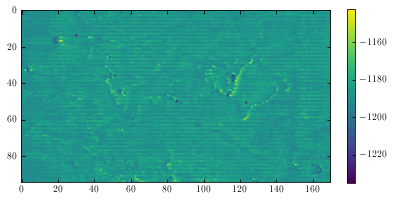

In [9]:
%matplotlib inline
ap = a.reshape(95,170,-1)
imshow(ap)
colorbar(fraction=0.026)
savefig('doc/acalibration.pdf')
savefig('doc/acalibration.png',dpi=1200)

## Pair compositions

In [10]:
n = len(r)
A = zeros((n,n)) # mixed area
B = zeros((n,n)) # difference

C = trapz(where(r.intensity>0,r.intensity,0)) # C

for i,ra in enumerate(r):
    
    A[i,i] = ra.overlap_area()
    
    for j,rb in enumerate(r[i+1:]):

        union = maximum(ra.z(),rb.z())
        union = minimum(union,r.intensity)
        union = trapz(where(union > 0,union,0))
        
        A[i,i + j + 1] = union
        A[i + j + 1,i] = union
        
        difference = minimum(ra.z(),rb.z())
        difference = minimum(difference,r.intensity)
        difference = trapz(where(difference > 0,difference,0))
        
        B[i,i + j + 1] = difference
        B[i + j + 1,i] = difference

(array([[31.40080134, 44.63141353, 79.44231022, 79.77642082, 44.00685344,
         81.02416613],
        [44.63141353, 26.63655143, 65.51433679, 81.27335956, 44.6669133 ,
         65.52258208],
        [79.44231022, 65.51433679, 50.18527718, 79.54889771, 80.73467916,
         65.24224418],
        [79.77642082, 81.27335956, 79.54889771, 79.35997204, 81.05571631,
         81.19003137],
        [44.00685344, 44.6669133 , 80.73467916, 81.05571631, 44.00042683,
         81.40924864],
        [81.02416613, 65.52258208, 65.24224418, 81.19003137, 81.40924864,
         65.17306885]]),
 array([[ 0.        , 13.40593923,  2.1437683 , 30.98435256, 31.39437473,
         15.54970406],
        [13.40593923,  0.        , 11.30749183, 24.72316391, 25.97006495,
         26.2870382 ],
        [ 2.1437683 , 11.30749183,  0.        , 49.99635151, 13.45102485,
         50.11610185],
        [30.98435256, 24.72316391, 49.99635151,  0.        , 42.30468256,
         63.34300952],
        [31.39437473, 25.970

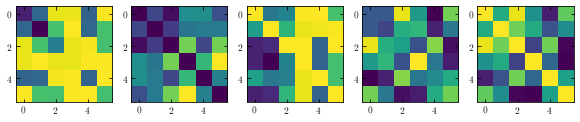

In [11]:
%matplotlib inline

fig,ax = subplots(1,5,figsize=(10,3))
ax[0].imshow(A)
ax[1].imshow(B)

ax[2].imshow(A.diagonal()/A)
ax[3].imshow((A-B))
ax[4].imshow((A-B)/A)

A,B,((A-B)/A)

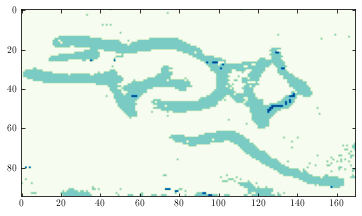

In [12]:
%matplotlib inline
idx = array([r.idx for r in result]).reshape(95,170)
imshow(idx,cmap='GnBu')

In [13]:
%%time
area = array([r.overlap_area() for r in result])
overlap_0 = array([r.overlap_0() for r in result])
area_fit = array([r.area_fit() for r in result])
area_0 = array([r.area_0() for r in result])
loss = array([r.loss() for r in result])
ss = array([trapz(r.spectra.intensity) for r in result])

CPU times: user 2min 30s, sys: 0 ns, total: 2min 30s
Wall time: 2min 30s


In [14]:
area = area.reshape(95,170,-1)
area_fit = area_fit.reshape(95,170,-1)
area_0 = area_0.reshape(95,170,-1)
loss = loss.reshape(95,170,-1)
ss = ss.reshape(95,170)

In [15]:
%matplotlib qt

fig,ax = subplots(1,6,figsize=(10,3))
fig.subplots_adjust(wspace=0.1,hspace=0.2,top=0.95,bottom=0.05,left=0.04,right=0.985)

for i,g in enumerate(r):
    
    ax[i].imshow(area[:,:,i]/ss,vmin=0,vmax=1)
    ax[i].set_title(r'%s'%g.label)
    
#savefig('doc/maps.png')

In [16]:
%matplotlib inline
%matplotlib qt

fig,ax = subplots(1,6,figsize=(10,3))
fig.subplots_adjust(wspace=0.1,hspace=0.2,top=0.95,bottom=0.05,left=0.04,right=0.985)

for i,g in enumerate(r):
    
    ax[i].imshow(area_fit[:,:,i]/area_0[:,:,i],vmin=0,vmax=1)
    ax[i].set_title(r'%s'%g.label)

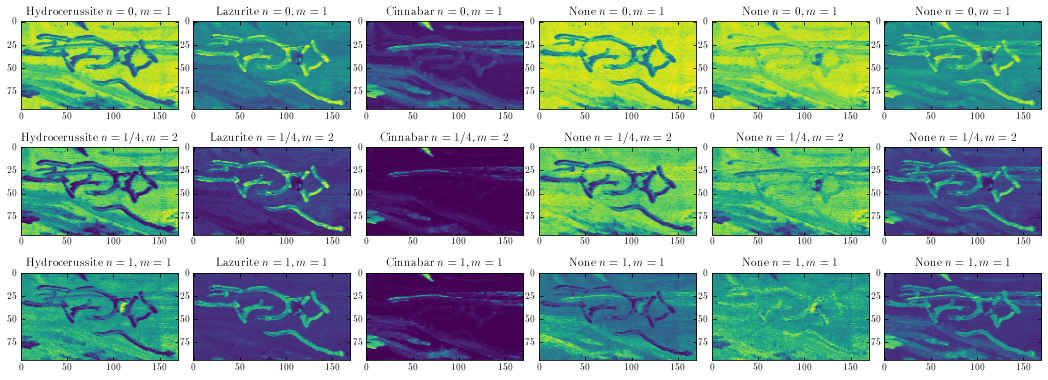

In [17]:
%matplotlib inline

fig,ax = subplots(3,6,figsize=(15,5.5))
#fig,ax = subplots(3,3,figsize=(5,4))
fig.subplots_adjust(wspace=0.1,hspace=0.2,top=0.95,bottom=0.05,left=0.04,right=0.985)

for i,g in enumerate(r):
    
    ax[0,i].imshow(area[:,:,i]/ss,vmin=0)
    ax[0,i].set_title(r'%s $n = 0, m=1$'%g.label)
    
    ax[1,i].imshow(((area_fit[:,:,i]/area_0[:,:,i])**0.25 * (area[:,:,i]/ss)**2),vmin=0)
    ax[1,i].set_title(r'%s $n = 1/4, m=2$'%g.label)
    
    ax[2,i].imshow((((area_fit[:,:,i]/area_0[:,:,i]) * (area[:,:,i]/ss))),vmin=0)
    ax[2,i].set_title(r'%s $n = 1,m=1$'%g.label)
    
#savefig('doc/wmaps.png')
#savefig('doc/wmaps.pdf')

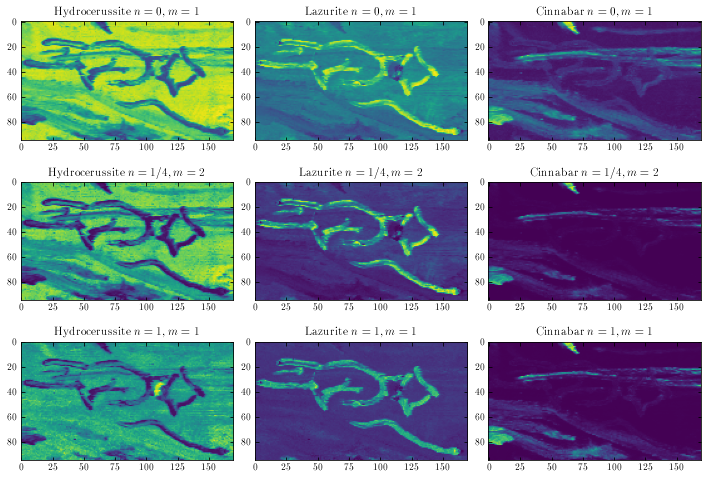

In [69]:
%matplotlib inline

fig,ax = subplots(3,3,figsize=(10,7))
fig.subplots_adjust(wspace=0.1,hspace=0.2,top=0.95,bottom=0.05,left=0.04,right=0.985)

for i,g in enumerate(r[:3]):
    
    ax[0,i].imshow(area[:,:,i]/ss,vmin=0)
    ax[0,i].set_title(r'%s $n = 0, m=1$'%g.label)
    
    ax[1,i].imshow(((area_fit[:,:,i]/area_0[:,:,i])**0.25 * (area[:,:,i]/ss)**2),vmin=0)
    ax[1,i].set_title(r'%s $n = 1/4, m=2$'%g.label)
    
    ax[2,i].imshow((((area_fit[:,:,i]/area_0[:,:,i]) * (area[:,:,i]/ss))),vmin=0)
    ax[2,i].set_title(r'%s $n = 1,m=1$'%g.label)
    
savefig('doc/wmaps2.png',dpi=1200)
#savefig('doc/wmaps.pdf')

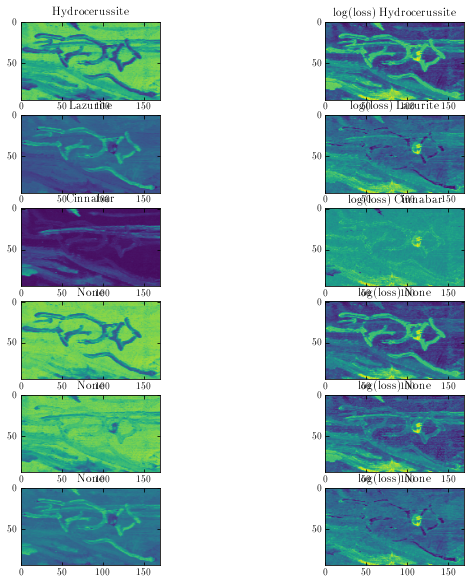

In [18]:
%matplotlib inline
fig,ax = subplots(6,2,figsize=(10,10))

for i,g in enumerate(r):

    ax[i,0].imshow(area[:,:,i]/ss,vmin=0,vmax=1)    
    ax[i,1].imshow(log(loss[:,:,i]))
    
    ax[i,0].set_title(r'%s'%g.label)
    ax[i,1].set_title(r'log(loss) %s'%g.label)

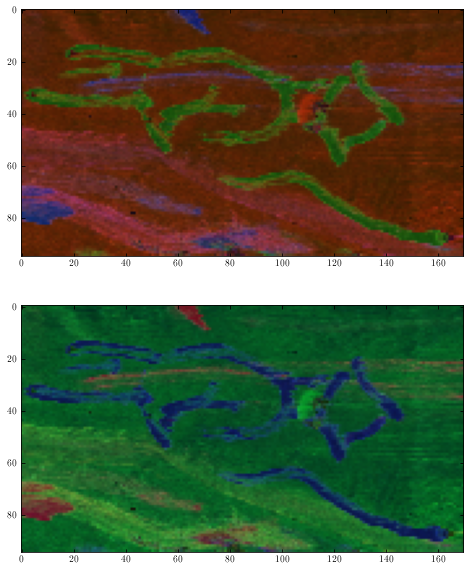

In [19]:
fig,ax = subplots(2,1,figsize=(10,10))

zarea = area / max(area)

sarea = zarea[:,:,:3].copy()

sarea[:,:,0] = zarea[:,:,2]
sarea[:,:,1] = zarea[:,:,0]
sarea[:,:,2] = zarea[:,:,1]

ax[0].imshow((zarea[:,:,:3]*255).astype(int))
ax[1].imshow((sarea*255).astype(int))